/home/changcheng/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<IPython.core.display.Javascript object>


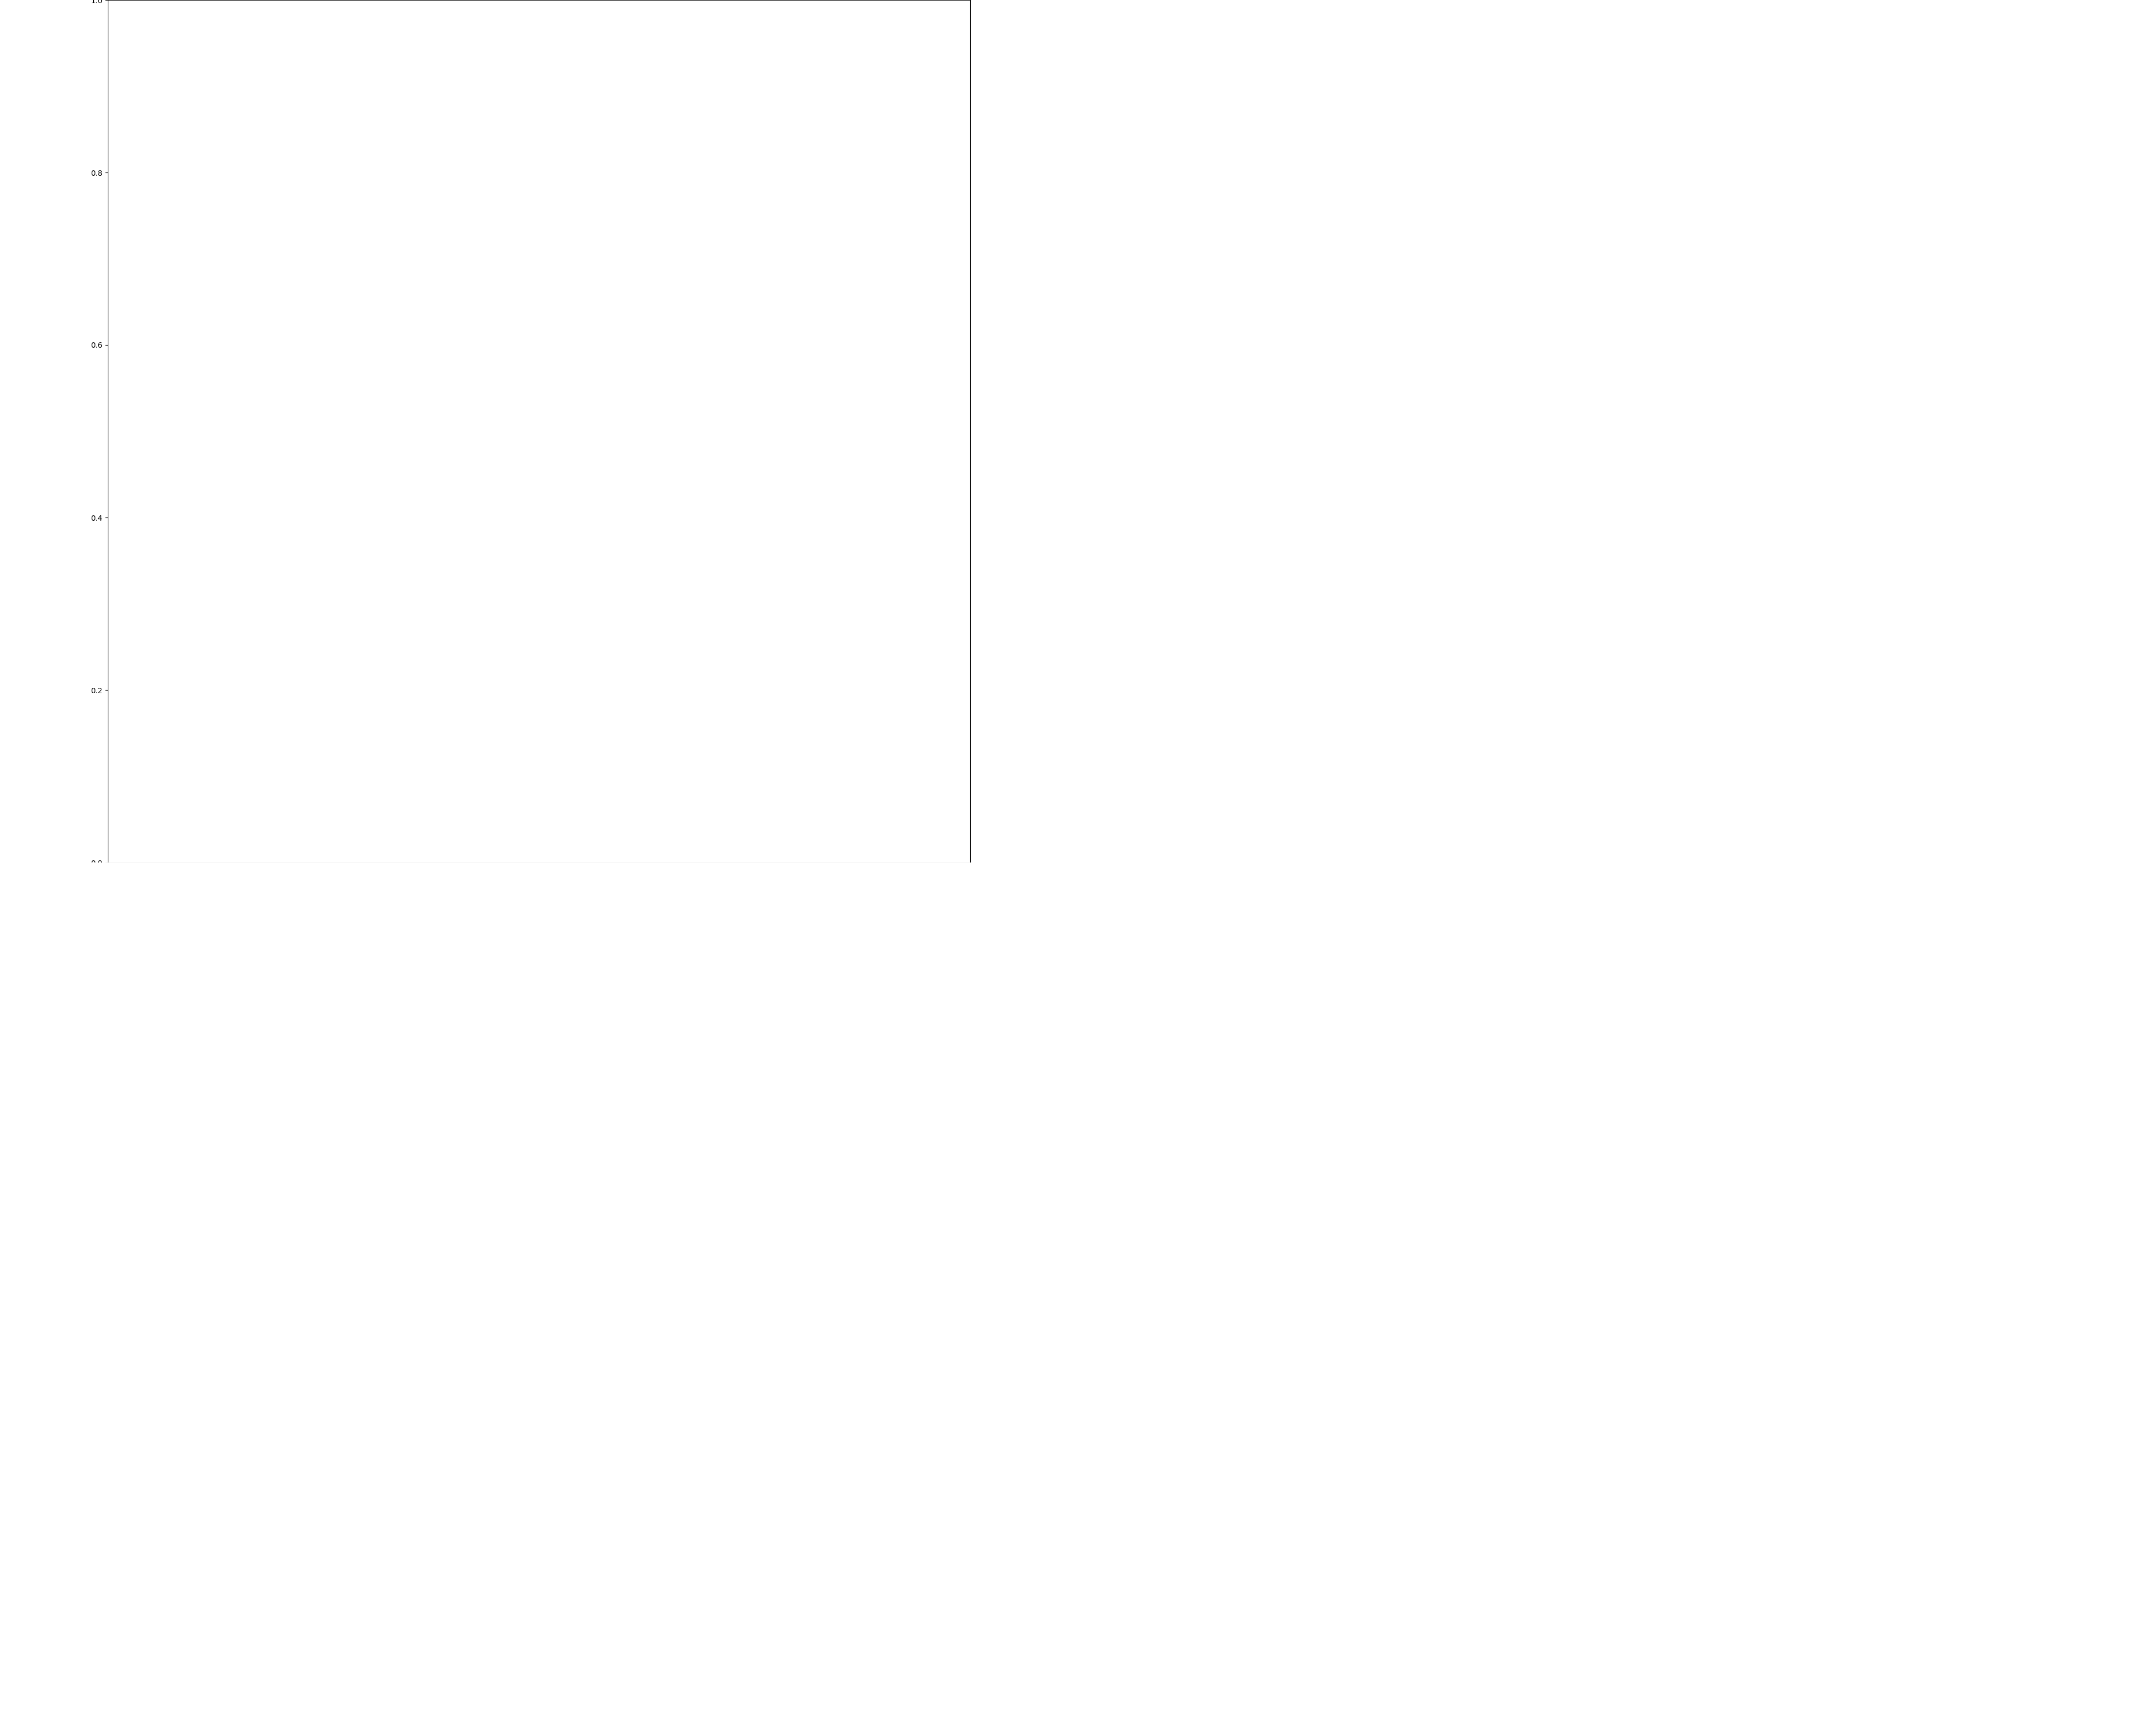

keras_yolo3/model_data/yolo.h5 model, anchors, and classes loaded.
get frame 0
image size:  (1920, 1080)
traffic light (1104, 365) (1133, 413)
image size:  (1920, 1080)
car (0, 518) (953, 846)
image size:  (1920, 1080)
person (1271, 458) (1322, 573)
image size:  (1920, 1080)
person (1630, 445) (1684, 567)
image size:  (1920, 1080)
person (1793, 425) (1850, 547)
[1077, 324, 82, 130]
[66, 104]
[0.21063739 0.28587693 0.20783602 ... 0.17217913 0.4397107  0.22761613]
get frame 1
image size:  (1920, 1080)
traffic light (1103, 362) (1130, 412)
image size:  (1920, 1080)
car (0, 519) (1001, 850)
image size:  (1920, 1080)
person (1803, 441) (1842, 526)
image size:  (1920, 1080)
person (1261, 456) (1315, 573)
image size:  (1920, 1080)
person (1628, 436) (1683, 564)
image size:  (1920, 1080)
person (1792, 425) (1849, 548)
[1077, 324, 82, 130]
[66, 104]
[0.27692097 0.4        0.4        ... 0.144638   0.34849563 0.153406  ]
0.788662314414978 (7, 12)
[1079, 327, 78, 123]
[66, 104]
[0.32690886 0.4   

TypeError: integer argument expected, got float

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glue import BlindNavigator
from utility import read_video
from PIL import Image
import numpy as np
import cv2

def test_det_track():
    video_path = 'data/IMG_9029.m4v'
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_axes([0,0,1,1])

    plt.ion()
    fig.show()
    fig.canvas.draw()
    navigator = BlindNavigator()
    for data in read_video(video_path):
        traffic_lights, detected_obstacles = navigator.detect_traffic_light(data)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        for (id_, bbox) in traffic_lights:
            assert  id_ < len(navigator.traffic_light_pool.trackers), 'id_ not valid'
#             bbox = [bbox[0] / data.shape[1], bbox[1] / data.shape[0], bbox[2] / data.shape[1], bbox[3] / data.shape[0]]
#             print(bbox)
#             p = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, alpha=1)
#             ax.add_patch(p)
            cv2.rectangle(data, tuple(bbox[:2]),tuple(bbox[2:4]), [255, 0, 0], 3)
    
        ax.imshow(data)

        fig.canvas.draw()
        ax.clear()

        
if __name__ == '__main__':
    test_det_track()